# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans  


# Load Dataset

In [4]:
# Load the dataset
df = pd.read_csv('Churn_Modelling.csv')

In [5]:
# Problem Definition and Dataset Analysis
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [7]:
print(df.describe())

         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

# Data Exploration and Visualization 

What are the missing values in the dataset?

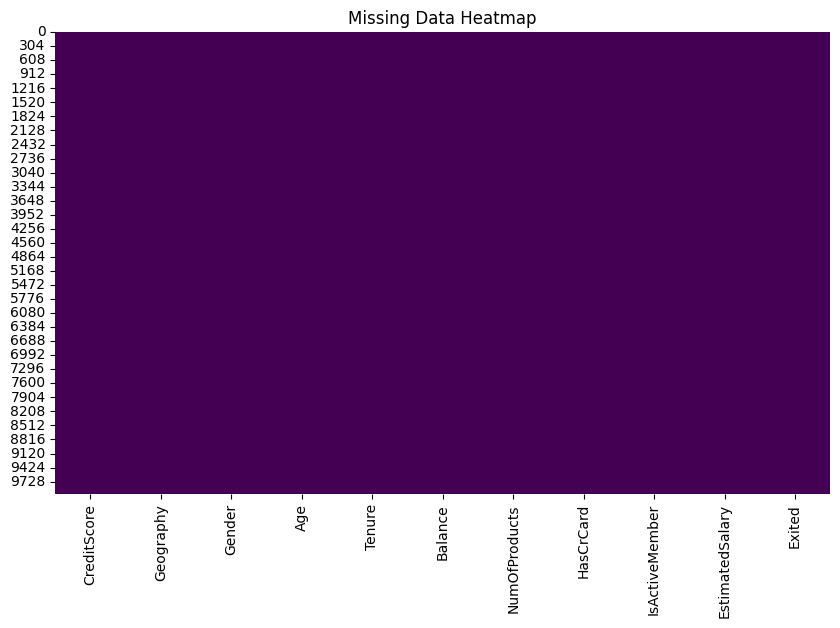

In [22]:

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

What is the distribution of the target variable (Exited)?

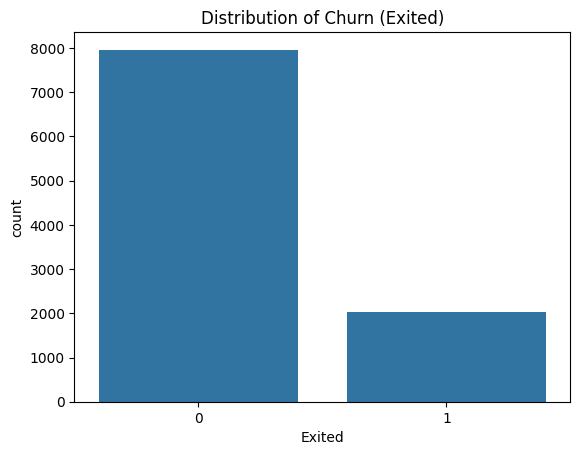

In [24]:
sns.countplot(x='Exited', data=df)
plt.title('Distribution of Churn (Exited)')
plt.show()

What are the correlations between numerical features?

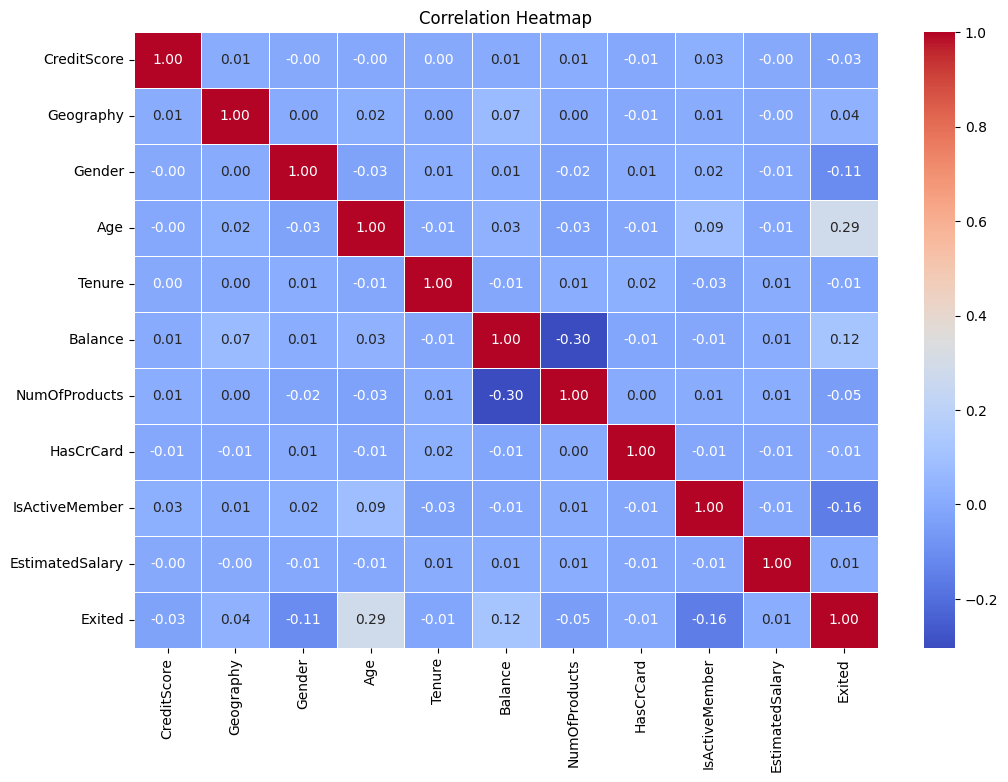

In [35]:
# Correlation heatmap to observe relationships between features
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Only numeric columns for correlation
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

What is the distribution of different features like Age, Balance, etc.?

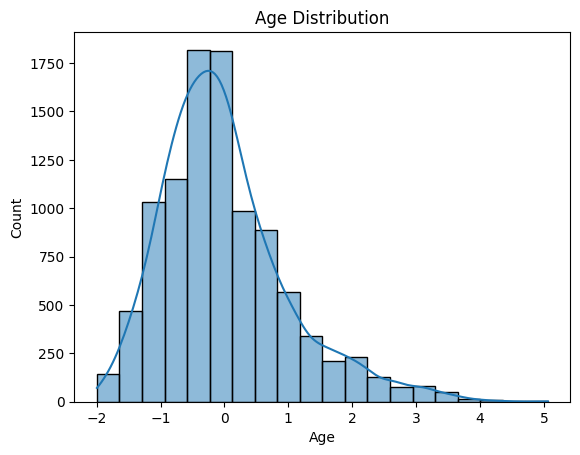

In [28]:
# Age distribution
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.show()



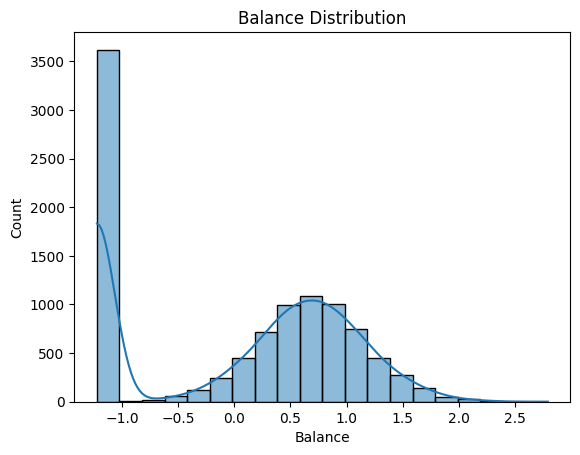

In [27]:
# Balance distribution
sns.histplot(df['Balance'], kde=True, bins=20)
plt.title('Balance Distribution')
plt.show()

How does Age impact the target variable (Exited)?

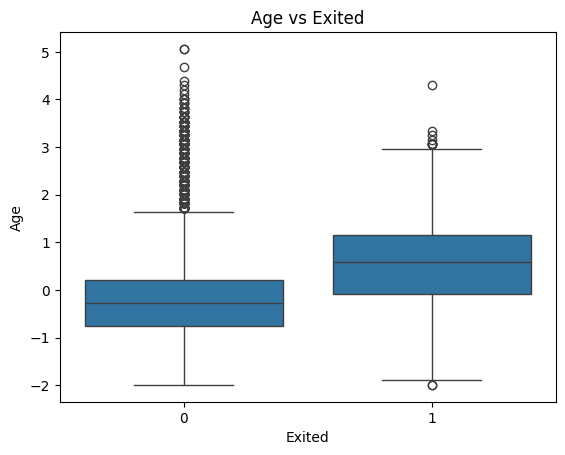

In [29]:
# Age vs Exited distribution
sns.boxplot(x='Exited', y='Age', data=df)
plt.title('Age vs Exited')
plt.show()

How does CreditScore impact the target variable (Exited)

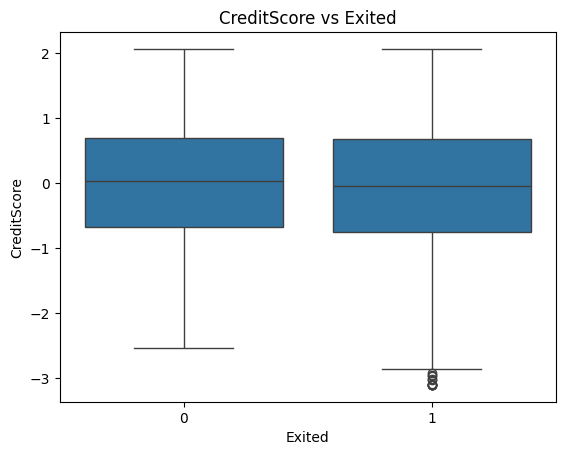

In [31]:
# CreditScore vs Exited distribution
sns.boxplot(x='Exited', y='CreditScore', data=df)
plt.title('CreditScore vs Exited')
plt.show()

Are there outliers in any of the numerical features?

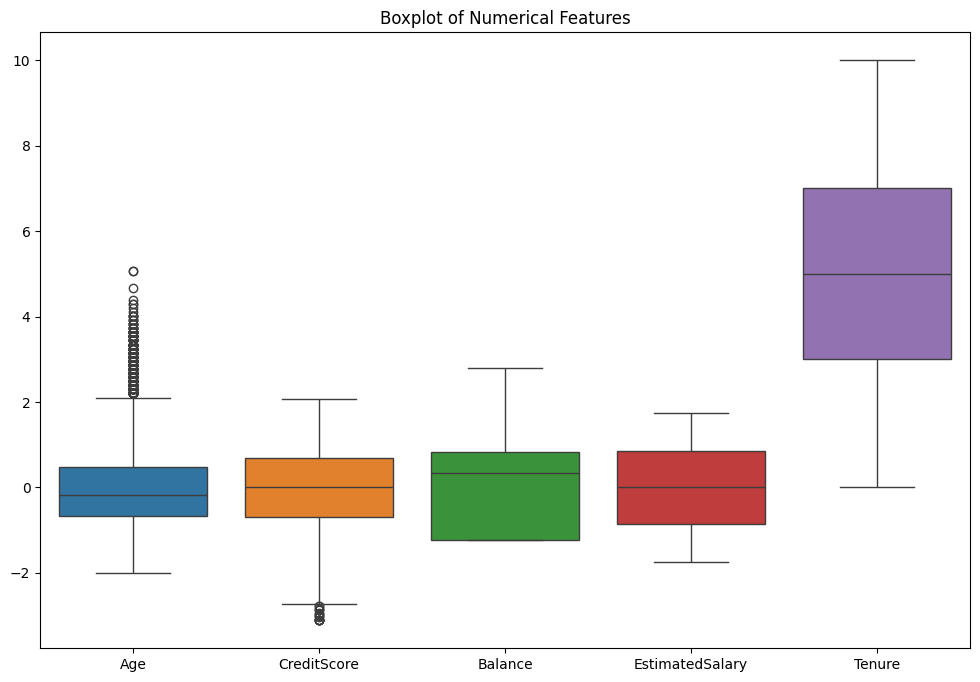

In [32]:
numerical_columns = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Boxplot of Numerical Features')
plt.show()

What is the distribution of churn across different customer demographics (e.g., age, credit score, salary, gender, geography)?

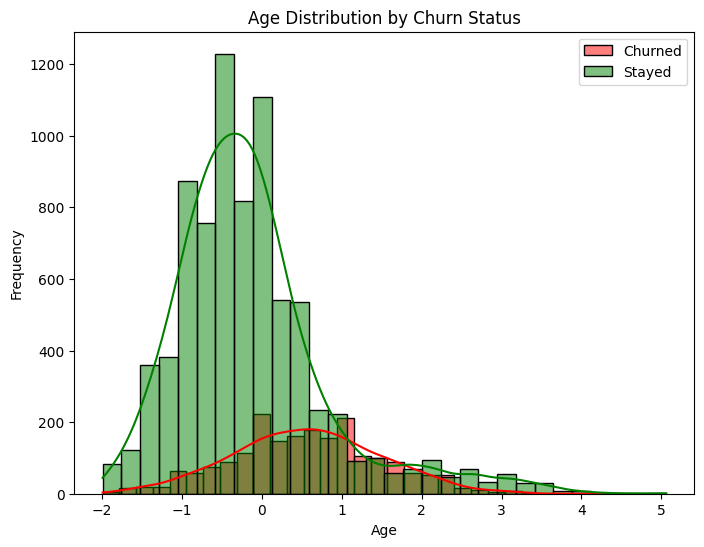

In [40]:
# Age vs Churn
plt.figure(figsize=(8, 6))
sns.histplot(df[df['Exited'] == 1]['Age'], color='red', kde=True, label='Churned', bins=30)
sns.histplot(df[df['Exited'] == 0]['Age'], color='green', kde=True, label='Stayed', bins=30)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


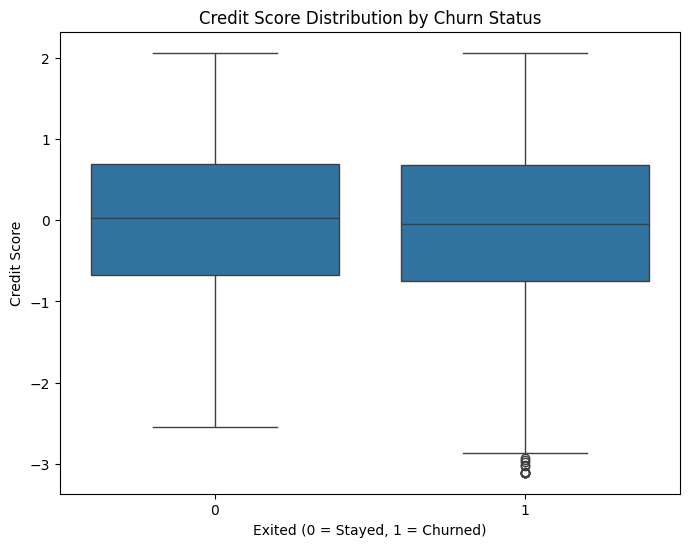

In [41]:
# Credit Score vs Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Exited', y='CreditScore', data=df)
plt.title('Credit Score Distribution by Churn Status')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Credit Score')
plt.show()

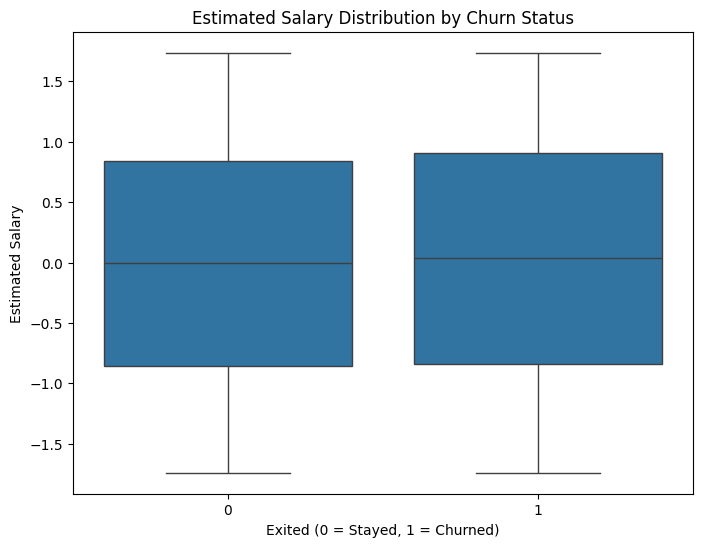

In [42]:
# Salary vs Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title('Estimated Salary Distribution by Churn Status')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Estimated Salary')
plt.show()

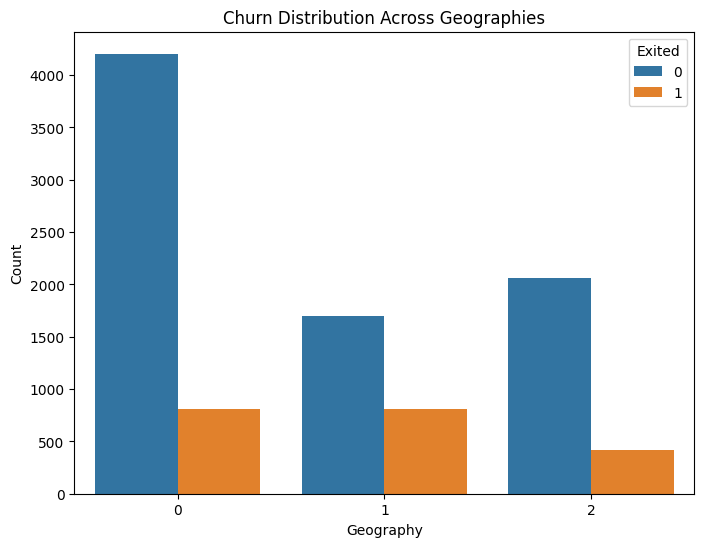

In [43]:
# Geography vs Churn
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn Distribution Across Geographies')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()

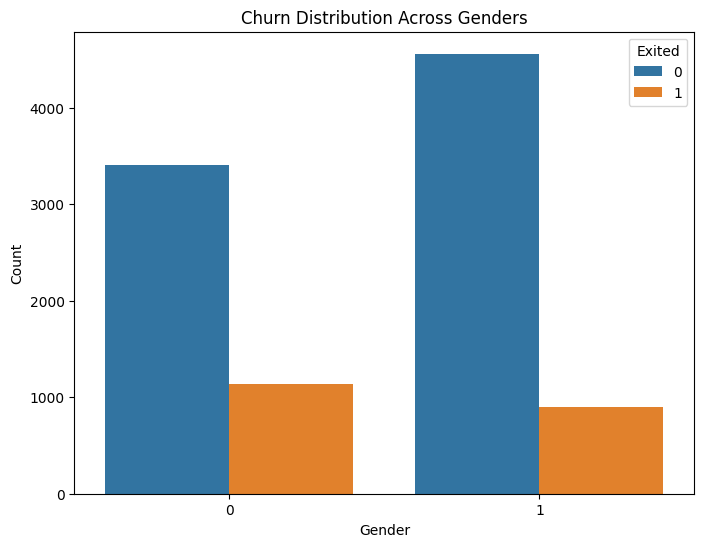

In [44]:
# Gender vs Churn
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Churn Distribution Across Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Does tenure (how long the customer has been with the bank) correlate with churn?

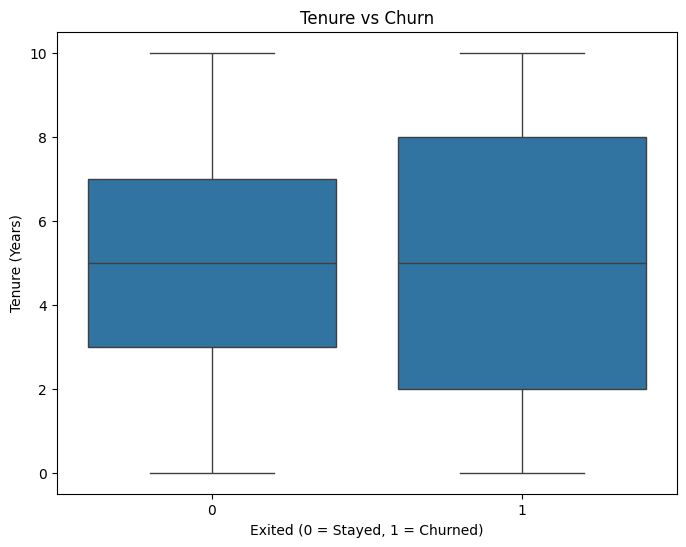

In [45]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Exited', y='Tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Tenure (Years)')
plt.show()

Is there a relationship between the number of products owned by a customer and the likelihood of churn?

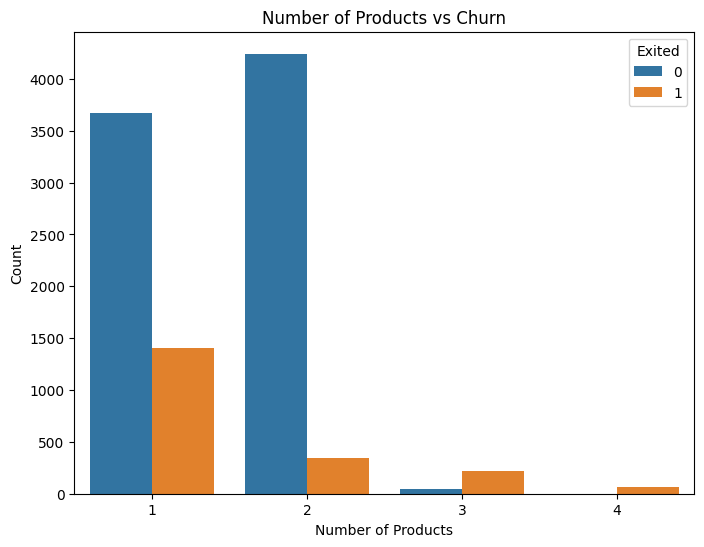

In [46]:
plt.figure(figsize=(8, 6))
sns.countplot(x='NumOfProducts', hue='Exited', data=df)
plt.title('Number of Products vs Churn')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.show()

How does the credit score and balance of a customer affect their likelihood of churning?

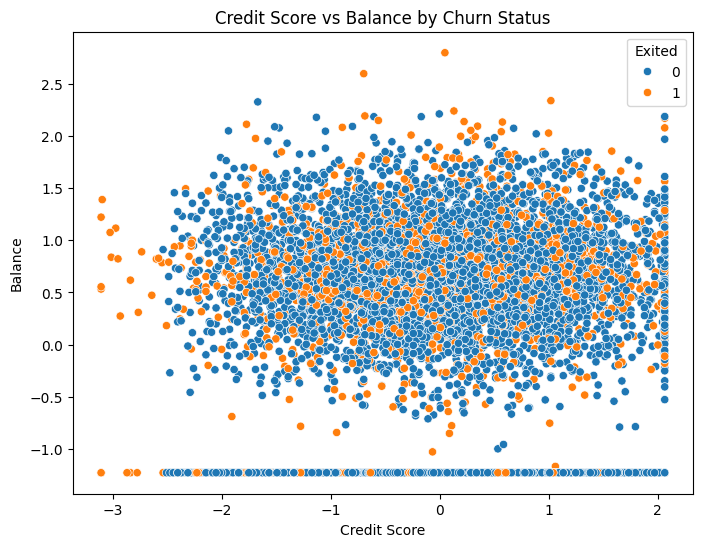

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CreditScore', y='Balance', hue='Exited', data=df)
plt.title('Credit Score vs Balance by Churn Status')
plt.xlabel('Credit Score')
plt.ylabel('Balance')
plt.show()

 Is there any significant difference in churn based on geographical location?

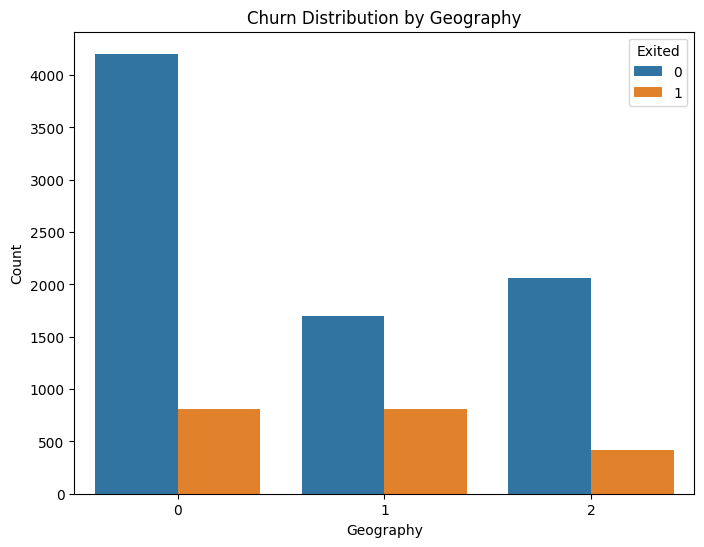

In [48]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn Distribution by Geography')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()

Does the presence of a credit card or a good salary impact churn behavior?

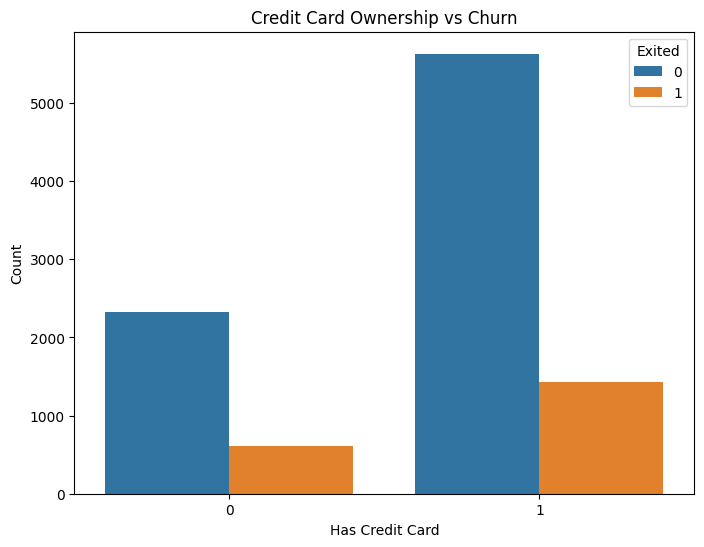

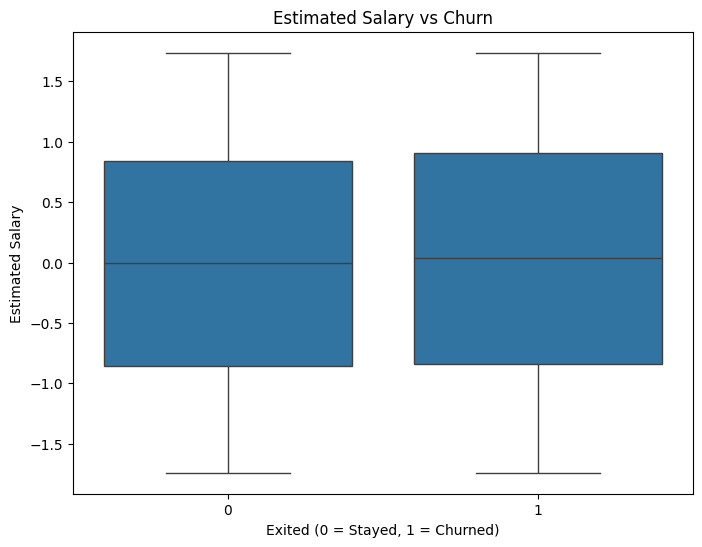

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Credit Card Ownership vs Churn')
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title('Estimated Salary vs Churn')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Estimated Salary')
plt.show()



How does age affect the likelihood of churn, especially in relation to salary and credit score?

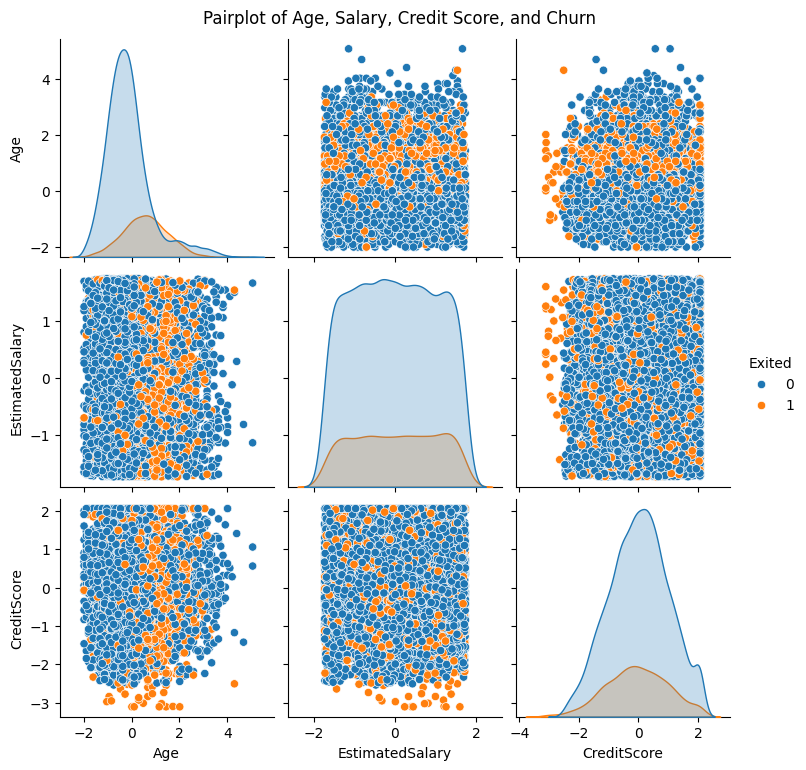

In [50]:
sns.pairplot(df[['Age', 'EstimatedSalary', 'CreditScore', 'Exited']], hue='Exited')
plt.suptitle('Pairplot of Age, Salary, Credit Score, and Churn', y=1.02)
plt.show()


Is there a noticeable trend in churn based on a specific combination of multiple features?


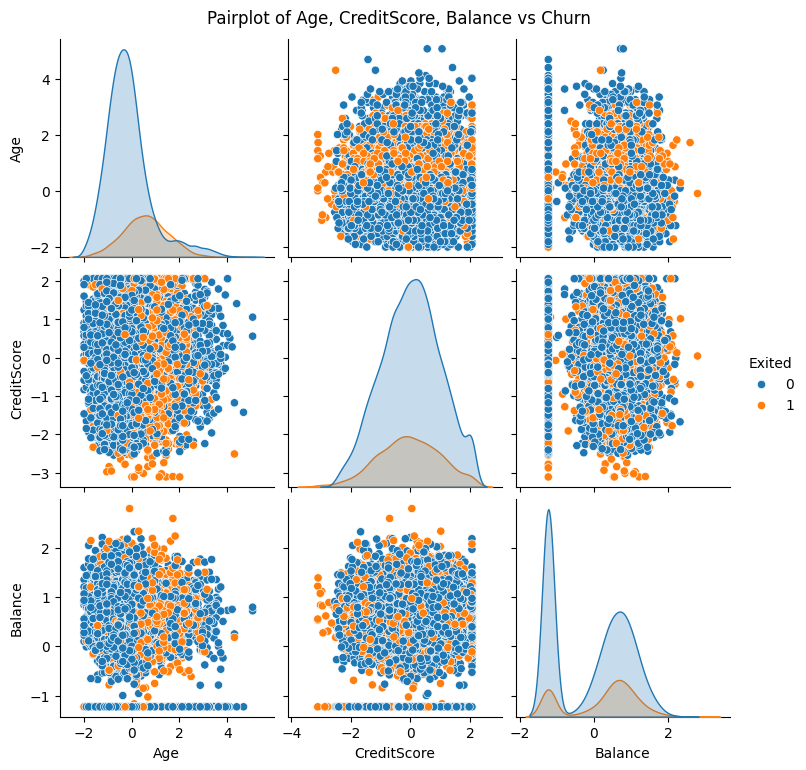

In [51]:
sns.pairplot(df[['Age', 'CreditScore', 'Balance', 'Exited']], hue='Exited')
plt.suptitle('Pairplot of Age, CreditScore, Balance vs Churn', y=1.02)
plt.show()

# Data Preprocessing


In [12]:
# Drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [13]:

# Encode 'Geography' and 'Gender' with separate label encoders
label_encoder_geography = LabelEncoder()
df['Geography'] = label_encoder_geography.fit_transform(df['Geography'])

label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])

In [14]:
# Standardize features
scaler = StandardScaler()
columns_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [15]:
# Save label encoders and scaler for later use in deployment
joblib.dump(label_encoder_geography, 'label_encoder_geography.pkl')
joblib.dump(label_encoder_gender, 'label_encoder_gender.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [16]:
# Save column order
columns_order = df.drop('Exited', axis=1).columns  # Save the order of features excluding the target
joblib.dump(columns_order, 'columns_order.pkl')

['columns_order.pkl']

# Split Data into Train and Test


In [17]:
# Splitting the data into training and testing sets
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definition and Training

In [18]:
# Define models to be used
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'KMeans': KMeans(n_clusters=2),  # Unsupervised model for clustering
    'GradientBoosting': GradientBoostingClassifier()  # Adding Gradient Boosting
}


In [52]:
# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if model supports predict_proba() and calculate ROC AUC
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None
    
    # Print results
    if roc_auc is not None:
        print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    else:
        print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC AUC: N/A")
    
    # Confusion Matrix and Classification Report
    print(f"{model_name} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred))

    

LogisticRegression - Accuracy: 0.8150, ROC AUC: 0.7636
LogisticRegression - Confusion Matrix:
 [[1559   48]
 [ 322   71]]
LogisticRegression - Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

RandomForest - Accuracy: 0.8645, ROC AUC: 0.8595
RandomForest - Confusion Matrix:
 [[1547   60]
 [ 211  182]]
RandomForest - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.46      0.57       393

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

SVM - Accuracy: 0.8260, ROC AU

# Cross-validation

In [20]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=kf)
    print(f"{model_name} - Cross-validation mean accuracy: {cv_scores.mean():.4f}")


LogisticRegression - Cross-validation mean accuracy: 0.8081
RandomForest - Cross-validation mean accuracy: 0.8611
SVM - Cross-validation mean accuracy: 0.8170
KNN - Cross-validation mean accuracy: 0.8259
[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Info] Number of positive: 1620, number of negative: 6380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

# Save the Trained Model

In [21]:
# Save the trained model, scaler, and label encoder for Geography and Gender
joblib.dump(models['RandomForest'], 'churn_model.pkl')  # Save the trained model (RandomForest in this case)

['churn_model.pkl']